# Project Description

The purpose of this project is to perform sentimental analysis of the drug reviews. Along with this, some important questions such as "what are the top 5 conditions mentioned in the dataset", "significant best and worst rated drugs for these top 5 conditions", "no of reviews per year", "top reviewed drugs" were answered through exploratory data analysis. The following steps were carried out:
1. Data Cleaning
2. Exploratory Data Analysis
3. Data visualization
4. Text preprocessing
5. Predictive models
6. Comparison using AUC score
7. Choose final model and tune  hyperparameters

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from nltk.corpus import stopwords
import seaborn as sns
import random
import os
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Exception handling method to open the data file
path = '../data/'

file = os.path.join(path,"drugsComTest_raw.csv")

try:
    df = pd.read_csv(file)
except FileNotFoundError as err:
    print("Please enter a valid file location: ",err)

# Data Dictionary

In [3]:
#Creating a Data Dictionary for the drug review dataset.

dtype=[]
unique_items=[]

for i in df.columns:
    dtype.append(df[i].dtype)
    unique_items.append(len(df[i].unique()))
    
data_dict=pd.DataFrame({'Dtype':dtype,
              'No.of unique items':unique_items,
               'Description':["Reviewer's unique identification number",
                              "Name of the drug that is reviewed",
                              "Condition that is being treated with the drug",
                              "Text of the review",
                              "Drug rating on a scale of 1(worst) to 10(best)",
                              "Review publish date",
                              "A measure for the usefulness of a review"]},
               index = ['uniqueID','drugName','condition','review','rating','date','usefulCount'])
data_dict

,Dtype,No.of unique items,Description
uniqueID,int64,53766,Reviewer's unique identification number
drugName,object,2637,Name of the drug that is reviewed
condition,object,709,Condition that is being treated with the drug
review,object,48280,Text of the review
rating,int64,10,Drug rating on a scale of 1(worst) to 10(best)
date,object,3566,Review publish date
usefulCount,int64,325,A measure for the usefulness of a review


# Data Cleaning

Data cleaning steps included:
1. Dropping the rows where 'condition' is Null
2. Eliminate instances of '&#039;' from the reviews
3. Eliminate instances of '\r\r\n' from the reviews.
4. Dropping the column 'uniqueID'
5. Delete the rows which contain " users found this comment helpful" in the condition column.

In [4]:
#Check for Null values in the columns

df.isnull().any()

uniqueID       False
drugName       False
condition       True
review         False
rating         False
date           False
usefulCount    False
dtype: bool

In [5]:
#Drop the rows where the 'condition' is Nan

nan_rows=df[df['condition'].isnull()]
df=df.drop(nan_rows.index)

In [6]:
#Data cleaning: Eliminated instances of '&#039;' from 'review'

df['review']=df['review'].str.replace('&#039;','')


In [7]:
#Drop the column uniqueID

df=df.drop(columns='uniqueID')

In [8]:
#Eliminated instances of '\r\r\n' in the reviews

df['review']=df['review'].str.replace('\r\r\n','')
df.reset_index(drop=True,inplace=True)

In [9]:
#Delete the rows which contain " users found this comment helpful" in the condition column.

#Boolean masking to select the bad rows

bad_rows=df[df.condition.str.contains(r'\d+</span> users found this comment helpful.',na=False)] 
df.drop(df.index[bad_rows.index], inplace=True)

#Reset the index

df.reset_index(drop=True,inplace=True)

# Descriptive Analysis

#### Through EDA, some important questions regarding the drugs for the top 5 conditions were answered.

In [10]:
print("Number of entries in the Dataframe: {:>5d}".format(df.shape[0]))
print("Number of columns: {:22d}".format(df.shape[1]))

Number of entries in the Dataframe: 53200
Number of columns:                      6


In [11]:
df.describe()

,rating,usefulCount
count,53200.000000,53200.000000
mean,6.978289,28.170282
std,3.286389,36.284596
min,1.000000,0.000000
25%,4.000000,6.000000
50%,8.000000,16.000000
75%,10.000000,36.000000
max,10.000000,949.000000


In [12]:
#No of unique conditions in the dataset
len(df['condition'].unique())

664

In [13]:
#Find the top 5 conditions

top_5_condt=df['condition'].value_counts().nlargest(5)

print("The top 5 reviewed conditions are: \n")
print("Condition\t\tNo.of Reviews")

for i,z in enumerate(top_5_condt):
    print('{:20s} {:>16d}'.format(top_5_condt.index[i],z))

The top 5 reviewed conditions are: 

Condition		No.of Reviews
Birth Control                    9648
Depression                       3095
Pain                             2100
Anxiety                          1908
Acne                             1847


In [14]:
#Extract the rows with the top 5 conditions

final_df=df[df['condition'].apply(lambda x:True if x in top_5_condt.index else False)]
final_df.reset_index(drop=True,inplace=True)

#Display the first 10 rows
final_df.head(10)

,drugName,condition,review,rating,date,usefulCount
0,Mirtazapine,Depression,"""Ive tried a few antidepressants over the year...",10,28-Feb-12,22
1,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4
2,Copper,Birth Control,"""Ive had the copper coil for about 3 months no...",6,6-Jun-16,1
3,Levora,Birth Control,"""I was on this pill for almost two years. It d...",2,16-Apr-11,3
4,Microgestin Fe 1 / 20,Acne,"""So I was on Ginanvi for about 3 months before...",3,22-Jun-17,1
5,Blisovi Fe 1 / 20,Birth Control,"""I absolutely love this product and recommend ...",10,3-Nov-17,4
6,Duloxetine,Pain,"""Been on 30mg Cymbalta for 2 weeks. Started ge...",9,27-Mar-12,32
7,NuvaRing,Birth Control,"""I was on this for 5 years (and birth control ...",7,17-Jun-11,0
8,Escitalopram,Depression,"""I am a 22 year old female college student. I ...",9,29-Apr-14,32
9,Aubra,Birth Control,"""Im absolutely DONE taking this horrible birth...",1,13-Dec-15,6


In [15]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18598 entries, 0 to 18597
Data columns (total 6 columns):
drugName       18598 non-null object
condition      18598 non-null object
review         18598 non-null object
rating         18598 non-null int64
date           18598 non-null object
usefulCount    18598 non-null int64
dtypes: int64(2), object(4)
memory usage: 871.9+ KB


In [16]:
#Rare conditions: Conditions which have been mentioned less than 5 times

print("Rare conditions are: \n")
conditions=df['condition'].value_counts()
for i in conditions[conditions<=10].index:
    print(i)

Rare conditions are: 

Gastroenteritis
Cutaneous Candidiasis
Lyme Disease
Paranoid Disorde
Seborrheic Dermatitis
Anemia
Eye Redness/Itching
Vulvodynia
Extrapyramidal Reaction
Macular Degeneration
Temporomandibular Joint Disorde
Postural Orthostatic Tachycardia Syndrome
Herpes Zoste
Inflammatory Bowel Disease
Glaucoma
Gouty Arthritis
Mitral Valve Prolapse
Angina Pectoris Prophylaxis
Tinea Cruris
Hypoestrogenism
Intraocular Hypertension
Photoaging of the Skin
Uveitis
Ischemic Stroke, Prophylaxis
Postoperative Ocular Inflammation
Methicillin-Resistant Staphylococcus Aureus Infection
Actinic Keratosis
Insulin Resistance Syndrome
Clostridial Infection
Tinnitus
Nocturnal Leg Cramps
Juvenile Rheumatoid Arthritis
Meniere's Disease
Agitated State
Anemia Associated with Chronic Renal Failure
Xerostomia
Atrial Flutte
min / sitagliptin)
Human Papillomavirus Prophylaxis
Hepatic Encephalopathy
Ovulation Induction
Duodenal Ulce
Hereditary Angioedema
Idiopathic Thrombocytopenic Purpura
Surgical Prophy

In [17]:
#Display the review which received the highest number of usefulcount

usefulcounts=df['usefulCount'].values #Convert 'usefulCount' into a ndarray

df.loc[df.usefulCount==np.max(usefulcounts)]
print(df.loc[df.usefulCount==np.max(usefulcounts)]['review'].iloc[0])

"Ive been on Zoloft 50mg for over two years. I am a more relaxed and easy-going person because of Zoloft.  Prior to starting the medicine, I was anxious all the time, worried constantly about everything, and suffered periods of depression and hopelessness.  Now I am a better wife, friend, and person in general."


In [18]:
#Converting the dates to the datetime format
pd.options.mode.chained_assignment = None #default:warn
final_df['date']=pd.to_datetime(final_df['date'])

#Creating a column for 'year'
years = final_df['date'].dt.year
final_df['year'] = years

#Find the number of reviews per year for each condition
cond_values=final_df.groupby('condition')['year'].value_counts()
cond_values.sort_index(inplace=True)

In [19]:
#Setting up the rc values

plt.rcParams['figure.figsize']=[13,8]
sns.set_style('whitegrid')
sns.set_context("talk",rc={'axes.labelsize':'20','axes.titlesize':'25','xtick.labelsize':15,'ytick.labelsize':15,
                           'axes.grid':True})

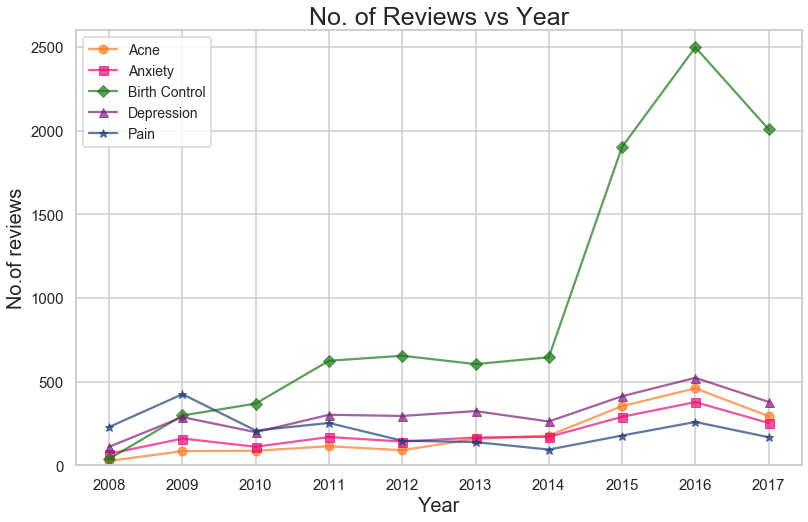

In [20]:
#Plotting the no.of reviews per year for the top 5 conditions

#It can be observed from the graph that the number of reviews for Birth Control drugs increased tremendously after 
#2014.

x=[i for i in range(0,10)]
fig,ax=plt.subplots()
colors=['#FF7923','#E80C7A','#1B7617','#7F1D7B','#1D3D76']
markers=['o','s','D','^','*']

for (cond,value),c,m in zip(cond_values.groupby(level=0),colors,markers):
    ax.plot(x,value,color=c,alpha=0.7,marker=m)
plt.ylim(0,2600)
plt.xticks(x,cond_values.index.get_level_values(1))
ax.set_title("No. of Reviews vs Year")
ax.set_xlabel("Year")
ax.set_ylabel("No.of reviews")
ax.legend(cond_values.index.get_level_values(0).unique(),fontsize=14,loc='upper left')
plt.show()

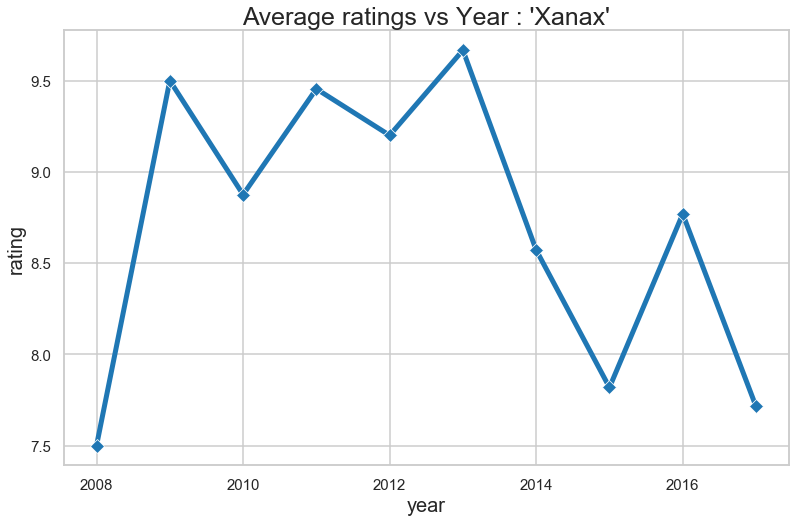

In [21]:
#Change in the average ratings of the popular drug 'Xanax'

drug=final_df[(final_df.drugName=='Xanax')&(final_df.condition=='Anxiety')][['year','rating']].groupby('year').mean()
sns.lineplot(drug['rating'].index,drug['rating'],linewidth = 5,marker = 'D',markersize = 10)

plt.title("Average ratings vs Year : 'Xanax'")
plt.show()

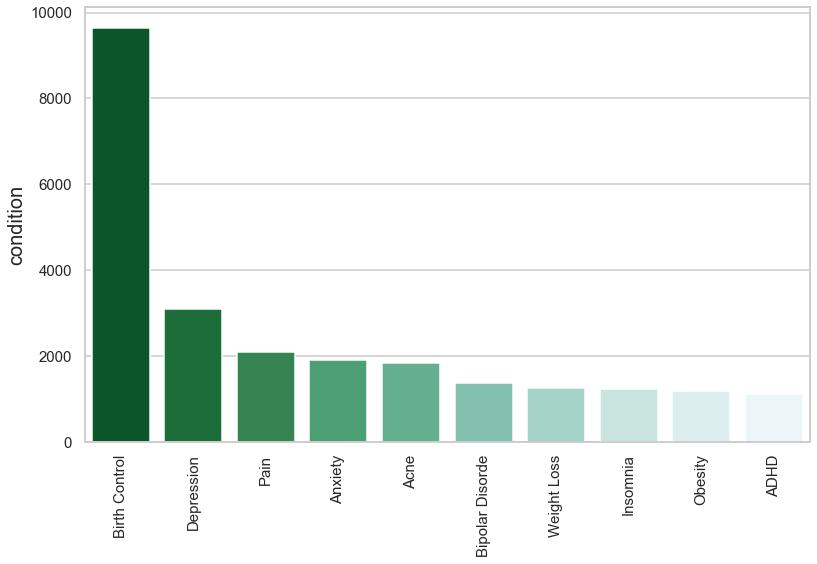

In [22]:
#Display the top 10 conditions

conditions = df['condition'].value_counts().nlargest(10)

g = sns.barplot(conditions.index,conditions,palette = "BuGn_r")
g.set_xticklabels(g.get_xticklabels(),rotation = 90)


plt.show()

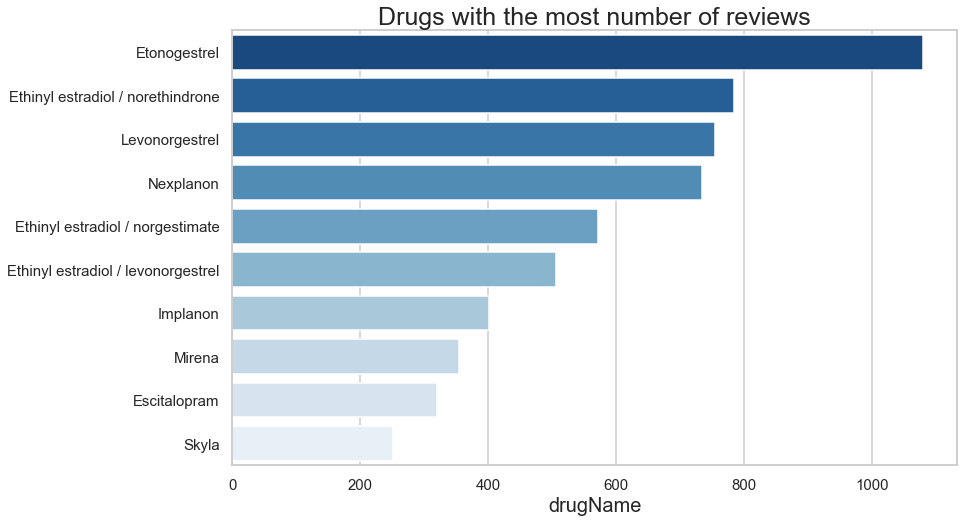

In [23]:
#Drugs with the most number of reviews

top_reviewed_drugs=final_df['drugName'].value_counts().nlargest(10)

sns.barplot(top_reviewed_drugs,top_reviewed_drugs.index,orient = "h",palette = "Blues_r",)
plt.title("Drugs with the most number of reviews")
plt.show()

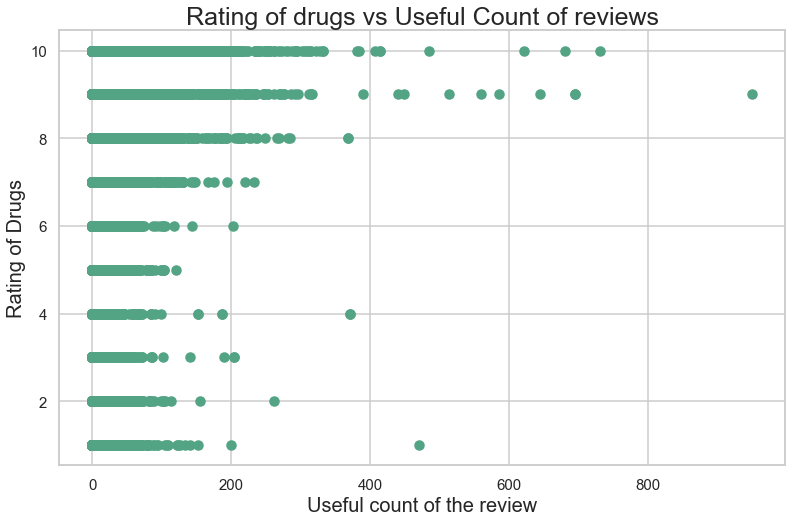

In [24]:
#Scatter plot of 'Ratings' and 'Usefulcounts'

x=final_df['rating'].values
y=final_df['usefulCount'].values

plt.scatter(y,x,color='#53A385')
plt.title("Rating of drugs vs Useful Count of reviews")
plt.xlabel("Useful count of the review")
plt.ylabel("Rating of Drugs")
plt.show()

In [25]:
entries_count = {}

for i in range(10):
    entries_count[i+1] = len(final_df[final_df['rating']==(i+1)])

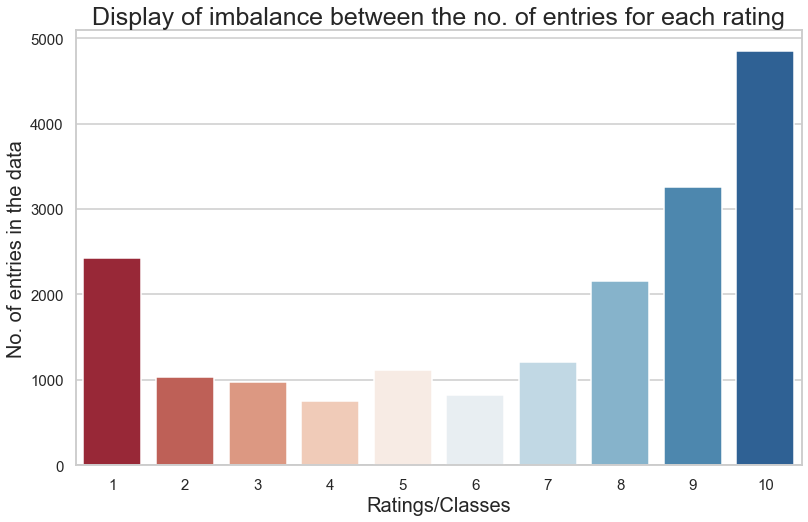

In [26]:
sns.barplot(list(entries_count.keys()),list(entries_count.values()),palette = "RdBu")
plt.title("Display of imbalance between the no. of entries for each rating")
plt.xlabel("Ratings/Classes")
plt.ylabel("No. of entries in the data")
plt.show()

After studying some of the reviews, I thought that the classes could be divided into the following manner:
-Combine rating 10 and 9 to form class 3 (Positive)
-Combine rating 8 and 7 to form class 2 (Mostly positive)
-Combine rating 4, 5 and 6 to form class 1 (Mostly negative)
-Combine rating 1,2 and 3 to form class 0 (Negative)

However, due to the imbalance in the classes, I decided to proceed in the following manner:
-Combine rating 1, 2 and 3 to form class 0(negative)
-Rating 10 forms class 1(positive)

This presents a well balanced classification problem. In the future, I would like to experiment with SMOTE and other techniques to solve the class imbalance problem.

# Significant drugs with the best and worst ratings

#### A significant number of reviews is when the number of a reviews for a drug is in the 80% quantile of the total number of reviews for a particular condition


In [27]:
#Find the significant drugs based on the reviews:

#A significant number of reviews is when the number of a reviews for a drug is in the 80% quantile of the total 
#number of reviews for a particular condition

#Define a function that uses quantiles to filter the reviews.
def quantile_group(df,value=0.80):
    quantile_value = df.quantile(value)
    return df[df>=quantile_value]

#Find the number of times each drug is reviewed
f=final_df.groupby('condition')['drugName'].value_counts()

#Apply quantile_group() to filter the drugs with most number of reviews
significant_drugs=f.groupby(level=0,group_keys=False).apply(quantile_group)

#Convert the resulting series into a dataframe
s=pd.DataFrame({'No.of reviews':significant_drugs.values,
              'drugName':significant_drugs.index.get_level_values(1),
              'condition':significant_drugs.index.get_level_values(0)})
p=pd.merge(s,final_df,how='inner',left_on=['condition','drugName'],right_on=['condition','drugName'])

#Find the average ratings for these drugs
m=p.groupby(['condition','drugName']).agg({'rating':np.mean,'No.of reviews':'first',})

#Find the top 10 significant "best" and "worst" drugs for each condition
sig_best=m.groupby(level=0,group_keys=False).apply(lambda x : x.nlargest(5,'rating'))
sig_worst=m.groupby(level=0,group_keys=False).apply(lambda x : x.nsmallest(5,'rating'))

In [28]:
#Top 5 significant drugs with the best rating, for the 5 conditions

sig_best

rating  No.of reviews
condition     drugName                                                   
Acne          Benzoyl peroxide / clindamycin      8.425532             94
              Accutane                            8.390909            110
              Isotretinoin                        8.266667            165
              Spironolactone                      8.083333             60
              Sulfamethoxazole / trimethoprim     8.062500             32
Anxiety       Xanax                               8.826087             92
              Alprazolam                          8.689394            132
              Diazepam                            8.490909             55
              Clonazepam                          8.426471            136
              Klonopin                            8.327273             55
Birth Control Ortho Evra                          7.277778             72
              Skyla                               7.206349            252
              Mirena                              7.050704            355
              Ethinyl estradiol / norelgestromin  7.037037            135
              Levonorgestrel                      6.976159            755
Depression    Lexapro                             8.098039            102
              Mirtazapine                         7.586667             75
              Bupropion                           7.464646            198
              Celexa                              7.410256             78
              Escitalopram                        7.407407            135
Pain          Acetaminophen / oxycodone           8.938596            114
              Methadone                           8.871795             39
              OxyContin                           8.816327             49
              Hydromorphone                       8.803030             66
              Lortab                              8.800000             20

In [29]:
#Top 5 significant drugs with the worst rating, for the 5 conditions

sig_worst

rating  No.of reviews
condition     drugName                                                  
Acne          Ethinyl estradiol / norethindrone  3.500000             40
              Ethinyl estradiol / norgestimate   5.836364             55
              Minocycline                        6.188119            101
              Adapalene                          6.629032             62
              Doxycycline                        7.014388            139
Anxiety       Hydroxyzine                        6.074766            107
              BuSpar                             6.285714             70
              Buspirone                          6.824427            131
              Duloxetine                         7.183673             49
              Escitalopram                       7.605405            185
Birth Control Norethindrone                      5.292929             99
              Nexplanon                          5.561308            734
              Ethinyl estradiol / norethindrone  5.610215            744
              Medroxyprogesterone                5.675325            154
              Drospirenone / ethinyl estradiol   5.693252            163
Depression    Effexor                            5.600000             65
              Viibryd                            5.955357            112
              Vortioxetine                       6.097345            113
              Duloxetine                         6.311927            109
              Venlafaxine                        6.737226            137
Pain          Tylenol with Codeine #3            4.148148             27
              Hysingla ER                        4.173913             23
              Lidocaine                          4.250000             24
              Acetaminophen / codeine            4.666667             24
              Nucynta                            5.785714             42

# Data preprocessing

Data preprocessing steps included - 
1. Removing punctuation,stop words
2. After studying some of the reviews, additional stop words were included.
3. Case normalization
4. Stemming
5. Binary bag of words transformation of the sentences


In [30]:
classes = {10:1,1:0,2:0,3:0}

In [31]:
# #Perform binary classification to predict if a review is positive or negative
# #Extracting the reviews which have rating == 1,2,3 or rating == 10

classify_f=final_df[(final_df['rating']==1)| (final_df['rating']==2) | (final_df['rating']==3) | (final_df['rating']==10)]
X=classify_f['review']
Y=classify_f['rating']

X.reset_index(drop=True,inplace=True)
Y.reset_index(drop=True,inplace=True)

Y = Y.replace(classes)

In [32]:
print("X shape : {}".format(X.shape))
print("Y shape : {}".format(Y.shape))
print("No of instances of Class 0(Negative) : {}".format(len(Y[Y==0])))
print("No of instances of Class 1(Positive) : {}".format(len(Y[Y==1])))

X shape : (9283,)
Y shape : (9283,)
No of instances of Class 0(Negative) : 4434
No of instances of Class 1(Positive) : 4849


In [33]:
# X = final_df['review'].copy()
# Y = final_df['rating']

In [34]:
#Remove punctuation, stopwords, numbers
#Case normalization

stopwords_list = ['onto','ive','alot','im','mg','medication','medications','like','amp','w','use','used','tried','would'
                  ,'id']

def process_text(sentence):
   
        nopunc = re.sub(r'[^a-zA-z]',' ',sentence)
        nopunc = [word.lower() for word in nopunc.split() if word.lower() not in stopwords.words('english')]
        return [word for word in nopunc if word not in stopwords_list]
   

In [35]:
#Stemming

def stem(list_of_words):
    stemmer = PorterStemmer()
    list_of_words = [stemmer.stem(word) for word in list_of_words]
    return list_of_words

In [36]:
#Lemmatization

# def lemmatized(list_of_words):
#     lemmatizer = WordNetLemmatizer()
#     list_of_words = [lemmatizer.lemmatize(word) for word in list_of_words]
#     return list_of_words

In [37]:
def join_words(list_of_words):
    
        return ' '.join(list_of_words)


In [38]:
#Call the functions

for i in range(len(X)):
    X[i] = process_text(X[i])
    X[i] = stem(X[i])
    X[i] = join_words(X[i])      

In [39]:
#Splitting the data into train and test data. Test size is 30% of the dataset

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

In [40]:
#Vectorize the data to form binary Bag of words

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

Y_train = Y_train.values
Y_test = Y_test.values

In [41]:
print("X_train shape : {}".format(X_train.shape))

X_train shape : (6498, 7086)


## Five classifiers were built and compared using confusion matrix, classification report and  AUC score.

# Naive Bayes

In [42]:
#Training a Multinomial Naive Bayes model

nb = BernoulliNB()
model=nb.fit(X_train,Y_train)

In [43]:
#Predicting the rating using the test data

preds_test = nb.predict(X_test)
preds_train = nb.predict(X_train)

In [44]:
#Evaluating the predictions
print("=====Accuracy score============\n")
print("Train accuracy score : {:.4f}".format(accuracy_score(Y_train,preds_train)))
print("Test accuracy score : {:.4f}".format(accuracy_score(Y_test,preds_test)))
print("\n=====Confusion Matrix==========\n ")
print(confusion_matrix(Y_test,preds_test))
print("\n=====Classification report=====\n")
print(classification_report(Y_test,preds_test))

=====Accuracy score============

Train accuracy score : 0.8780
Test accuracy score : 0.8212

=====Confusion Matrix==========
 
[[1086  264]
 [ 234 1201]]

=====Classification report=====

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1350
           1       0.82      0.84      0.83      1435

    accuracy                           0.82      2785
   macro avg       0.82      0.82      0.82      2785
weighted avg       0.82      0.82      0.82      2785



In [45]:
probs = nb.predict_proba(X_test)[:,1]

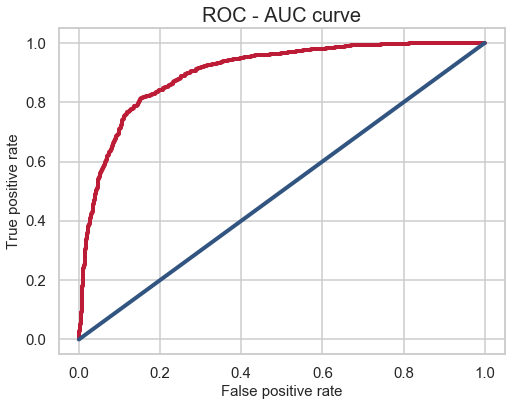

In [46]:
fpr, tpr, thresholds = roc_curve(Y_test,probs)

plt.figure(figsize = (8,6))
plt.plot(fpr,tpr,'-', color = '#BD1C37',linewidth = 4)
plt.plot([0.0,1.0],[0.0,1.0],color = '#315580',linewidth = 4)
plt.title("ROC - AUC curve",fontsize = 20)
plt.xlabel("False positive rate",fontsize = 15)
plt.ylabel("True positive rate",fontsize = 15)
plt.show()

In [47]:
print('AUC SCORE : {:.4}'.format(auc(fpr,tpr)))

AUC SCORE : 0.9009


# Logistic Regression

In [48]:
#Training a Logistic Regression model

lr = LogisticRegression()
model=lr.fit(X_train,Y_train)

In [49]:
#Predicting the rating using the test data

preds_test = lr.predict(X_test)
preds_train = lr.predict(X_train)


In [50]:
#Evaluating the predictions
print("=====Accuracy score============\n")
print("Train accuracy score : {:.4f}".format(accuracy_score(Y_train,preds_train)))
print("Test accuracy score : {:.4f}".format(accuracy_score(Y_test,preds_test)))
print("\n=====Confusion Matrix==========\n ")
print(confusion_matrix(Y_test,preds_test))
print("\n=====Classification report=====\n")
print(classification_report(Y_test,preds_test))

=====Accuracy score============

Train accuracy score : 0.9752
Test accuracy score : 0.8650

=====Confusion Matrix==========
 
[[1170  180]
 [ 196 1239]]

=====Classification report=====

              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1350
           1       0.87      0.86      0.87      1435

    accuracy                           0.86      2785
   macro avg       0.86      0.87      0.86      2785
weighted avg       0.87      0.86      0.87      2785



In [51]:
probs = lr.predict_proba(X_test)[:,1]

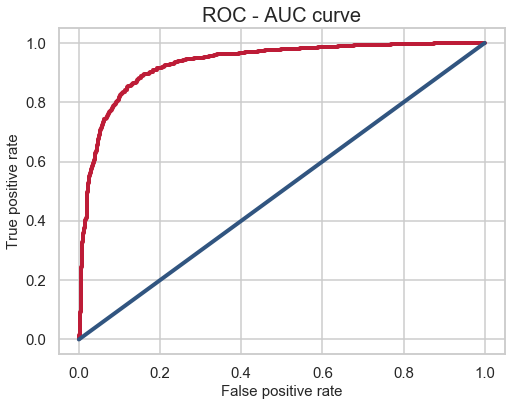

In [52]:
fpr, tpr, thresholds = roc_curve(Y_test,probs)

plt.figure(figsize = (8,6))
plt.plot(fpr,tpr,'-', color = '#BD1C37',linewidth = 4)
plt.plot([0.0,1.0],[0.0,1.0],color = '#315580',linewidth = 4)
plt.title("ROC - AUC curve",fontsize = 20)
plt.xlabel("False positive rate",fontsize = 15)
plt.ylabel("True positive rate",fontsize = 15)
plt.show()

In [53]:
print('AUC SCORE : {:.4}'.format(auc(fpr,tpr)))

AUC SCORE : 0.9321


# Support Vector Machine

In [54]:
#Training a support vector machine 
#Default kernel is RBF
#if gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,

svc = SVC(gamma = 'scale',probability = True)
model=svc.fit(X_train,Y_train)

In [55]:
#Predicting the rating using the test data

preds_test = svc.predict(X_test)
preds_train = svc.predict(X_train)

In [56]:
#Evaluating the predictions
print("=====Accuracy score============\n")
print("Train accuracy score : {:.4f}".format(accuracy_score(Y_train,preds_train)))
print("Test accuracy score : {:.4f}".format(accuracy_score(Y_test,preds_test)))
print("\n=====Confusion Matrix==========\n ")
print(confusion_matrix(Y_test,preds_test))
print("\n=====Classification report=====\n")
print(classification_report(Y_test,preds_test))

=====Accuracy score============

Train accuracy score : 0.9671
Test accuracy score : 0.8704

=====Confusion Matrix==========
 
[[1156  194]
 [ 167 1268]]

=====Classification report=====

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      1350
           1       0.87      0.88      0.88      1435

    accuracy                           0.87      2785
   macro avg       0.87      0.87      0.87      2785
weighted avg       0.87      0.87      0.87      2785



In [57]:
probs = svc.predict_proba(X_test)[:,1]

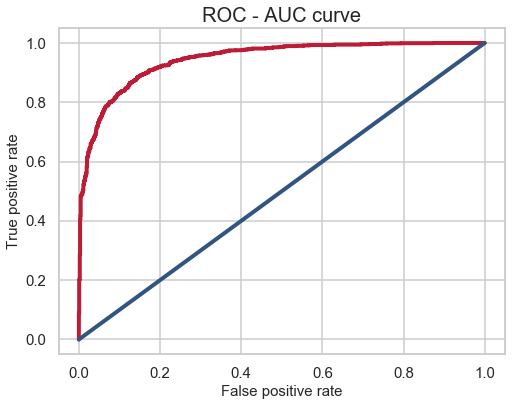

In [58]:
fpr, tpr, thresholds = roc_curve(Y_test,probs)

plt.figure(figsize = (8,6))
plt.plot(fpr,tpr,'-', color = '#BD1C37',linewidth = 4)
plt.plot([0.0,1.0],[0.0,1.0],color = '#315580',linewidth = 4)
plt.title("ROC - AUC curve",fontsize = 20)
plt.xlabel("False positive rate",fontsize = 15)
plt.ylabel("True positive rate",fontsize = 15)
plt.show()

In [59]:
print('AUC SCORE : {:.4}'.format(auc(fpr,tpr)))

AUC SCORE : 0.9447


# Decision tree classifier

In [60]:
#Training a Decision Tree classifier model

d_tree = DecisionTreeClassifier()
model=d_tree.fit(X_train,Y_train)

In [61]:
#Predicting the rating using the test data

preds_test = d_tree.predict(X_test)
preds_train = d_tree.predict(X_train)

In [62]:
#Evaluating the predictions
print("=====Accuracy score============\n")
print("Train accuracy score : {:.4f}".format(accuracy_score(Y_train,preds_train)))
print("Test accuracy score : {:.4f}".format(accuracy_score(Y_test,preds_test)))
print("\n=====Confusion Matrix==========\n ")
print(confusion_matrix(Y_test,preds_test))
print("\n=====Classification report=====\n")
print(classification_report(Y_test,preds_test))

=====Accuracy score============

Train accuracy score : 1.0000
Test accuracy score : 0.7522

=====Confusion Matrix==========
 
[[1004  346]
 [ 344 1091]]

=====Classification report=====

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1350
           1       0.76      0.76      0.76      1435

    accuracy                           0.75      2785
   macro avg       0.75      0.75      0.75      2785
weighted avg       0.75      0.75      0.75      2785



In [63]:
probs = d_tree.predict_proba(X_test)[:,1]

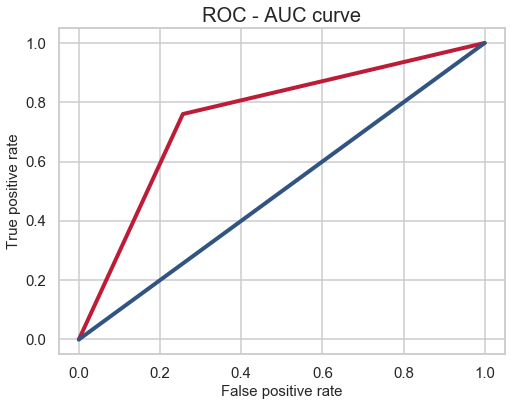

In [64]:
fpr, tpr, thresholds = roc_curve(Y_test,probs)

plt.figure(figsize = (8,6))
plt.plot(fpr,tpr,'-', color = '#BD1C37',linewidth = 4)
plt.plot([0.0,1.0],[0.0,1.0],color = '#315580',linewidth = 4)
plt.title("ROC - AUC curve",fontsize = 20)
plt.xlabel("False positive rate",fontsize = 15)
plt.ylabel("True positive rate",fontsize = 15)
plt.show()

In [65]:
print('AUC SCORE : {:.4}'.format(auc(fpr,tpr)))

AUC SCORE : 0.752


# Random Forest Classifier

In [66]:
#Training a Random Forest classifier model

forest = RandomForestClassifier()
model=forest.fit(X_train,Y_train)

In [67]:
#Predicting the rating using the test data

preds_test = forest.predict(X_test)
preds_train = forest.predict(X_train)

In [68]:
#Evaluating the predictions

print("=====Accuracy score============\n")
print("Train accuracy score : {:.4f}".format(accuracy_score(Y_train,preds_train)))
print("Test accuracy score : {:.4f}".format(accuracy_score(Y_test,preds_test)))
print("\n=====Confusion Matrix==========\n ")
print(confusion_matrix(Y_test,preds_test))
print("\n=====Classification report=====\n")
print(classification_report(Y_test,preds_test))

=====Accuracy score============

Train accuracy score : 0.9949
Test accuracy score : 0.8054

=====Confusion Matrix==========
 
[[1162  188]
 [ 354 1081]]

=====Classification report=====

              precision    recall  f1-score   support

           0       0.77      0.86      0.81      1350
           1       0.85      0.75      0.80      1435

    accuracy                           0.81      2785
   macro avg       0.81      0.81      0.81      2785
weighted avg       0.81      0.81      0.81      2785



In [69]:
probs = forest.predict_proba(X_test)[:,1]

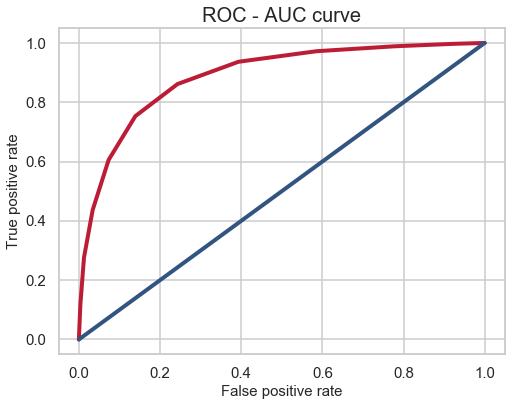

In [70]:
fpr, tpr, thresholds = roc_curve(Y_test,probs)

plt.figure(figsize = (8,6))
plt.plot(fpr,tpr,'-', color = '#BD1C37',linewidth = 4)
plt.plot([0.0,1.0],[0.0,1.0],color = '#315580',linewidth = 4)
plt.title("ROC - AUC curve",fontsize = 20)
plt.xlabel("False positive rate",fontsize = 15)
plt.ylabel("True positive rate",fontsize = 15)
plt.show()

In [71]:
print('AUC SCORE : {:.4}'.format(auc(fpr,tpr)))

AUC SCORE : 0.8868


# Final model

It is evident that both Decision tree and random forest are overfitting. This can be solved by applying regularization. However, for this problem Support Vector Machine was selected as the final model based on the AUC score even though it takes longer computing time. Hyperparameters were tuned using GridSearchCV

In [72]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2,scoring = "f1_weighted")
grid.fit(X_train,Y_train)
print(grid.best_estimator_)
print(grid.best_params_)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   9.7s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.7s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  10.6s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  10.1s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   9.6s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   8.4s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   8.6s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   4.6s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   4.5s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] .

[CV] ..................... C=1, gamma=0.01, kernel=poly, total=   8.7s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=   5.1s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=   5.1s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=   5.1s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   8.6s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   7.1s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   9.7s
[CV] C=1, gamma=0.001, kernel=poly ...................................
[CV] .

[CV] ..................... C=100, gamma=0.1, kernel=rbf, total=   8.7s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=100, gamma=0.1, kernel=rbf, total=   8.8s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=100, gamma=0.1, kernel=rbf, total=   8.9s
[CV] C=100, gamma=0.1, kernel=poly ...................................
[CV] .................... C=100, gamma=0.1, kernel=poly, total=   8.9s
[CV] C=100, gamma=0.1, kernel=poly ...................................
[CV] .................... C=100, gamma=0.1, kernel=poly, total=   6.1s
[CV] C=100, gamma=0.1, kernel=poly ...................................
[CV] .................... C=100, gamma=0.1, kernel=poly, total=   7.8s
[CV] C=100, gamma=0.1, kernel=sigmoid ................................
[CV] ................. C=100, gamma=0.1, kernel=sigmoid, total=   3.4s
[CV] C=100, gamma=0.1, kernel=sigmoid ................................
[CV] .

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 17.3min finished


SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


In [73]:
svc = SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
svc.fit(X_train,Y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [74]:
preds_test = svc.predict(X_test)
preds_train = svc.predict(X_train)


In [75]:
#Evaluating the predictions

print("=====Accuracy score============\n")
print("Train accuracy score : {:.4f}".format(accuracy_score(Y_train,preds_train)))
print("Test accuracy score : {:.4f}".format(accuracy_score(Y_test,preds_test)))
print("\n=====Confusion Matrix==========\n ")
print(confusion_matrix(Y_test,preds_test))
print("\n=====Classification report=====\n")
print(classification_report(Y_test,preds_test))

=====Accuracy score============

Train accuracy score : 0.9948
Test accuracy score : 0.8740

=====Confusion Matrix==========
 
[[1189  161]
 [ 190 1245]]

=====Classification report=====

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1350
           1       0.89      0.87      0.88      1435

    accuracy                           0.87      2785
   macro avg       0.87      0.87      0.87      2785
weighted avg       0.87      0.87      0.87      2785



In [76]:
probs = svc.predict_proba(X_test)[:,1]

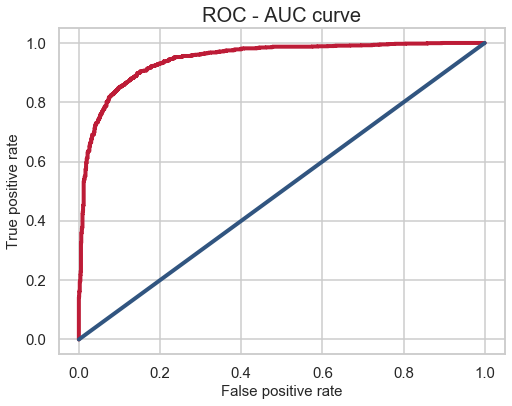

In [77]:
fpr, tpr, thresholds = roc_curve(Y_test,probs)

plt.figure(figsize = (8,6))
plt.plot(fpr,tpr,'-', color = '#BD1C37',linewidth = 4)
plt.plot([0.0,1.0],[0.0,1.0],color = '#315580',linewidth = 4)
plt.title("ROC - AUC curve",fontsize = 20)
plt.xlabel("False positive rate",fontsize = 15)
plt.ylabel("True positive rate",fontsize = 15)
plt.show()

In [78]:
print('AUC SCORE : {:.4}'.format(auc(fpr,tpr)))

AUC SCORE : 0.9465


# Test Cases

Following are some random test cases and their sentimental analysis results

In [79]:
classify_f['rating'].replace(classes,inplace = True)

In [80]:
#Testing the model using a test function

def test(args):
        
        r=classify_f['review'][args]
        r = process_text(r)
        r = stem(r)
        r = join_words(r)
        t=vectorizer.transform([r])
        print("Actual rating: ",classify_f['rating'][args])
        print("Predicted rating: ",svc.predict(t)[0],'\n')

In [81]:
#Generate 5 test cases using random reviews, print the actual and predicted ratings

#From the test case results it can be observed that 4 out of 5 cases have been predicted accurately

for i in range(5):
    print("Case",i+1)
    test(random.randint(0,7000))

Case 1
Actual rating:  1
Predicted rating:  1 

Case 2
Actual rating:  0
Predicted rating:  0 

Case 3
Actual rating:  0
Predicted rating:  0 

Case 4
Actual rating:  1
Predicted rating:  1 

Case 5
Actual rating:  0
Predicted rating:  0 

